###  Install Required Libraries



In [1]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install requests
%pip install tabulate
%pip install scikit-learn
%pip install nltk
"""


'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install requests\n%pip install tabulate\n%pip install scikit-learn\n%pip install nltk\n'

In [2]:
from openai import OpenAI
from tools import get_markdown
import sys
import json
from tqdm import tqdm
from pydantic import BaseModel
from enum import Enum
from key import get_key_openai, get_key_llama
from types import SimpleNamespace
from shot_learning_examples.examples import example1_actors, example2_actors, example1_hl, example2_hl, example1_ll, example2_ll, example1_map, example2_map
from structured_ouptut_models.data_model import DocumentDescription, Actor, Actors, LowLevelGoal, LowLevelGoals, HighLevelGoal, HighLevelGoals, API, APIMapping
from goal_evaluator import GoalEvaluator
from tabulate import tabulate # Import tabulate for nice table formatting

# from llamaapi import LlamaAPI

/Users/andreabioddo/Desktop/POLITO/LLM/progetto/LLM_Agent-Goal_Oriented_API_Alignement/shot_learning_examples/examples.py:175: SyntaxWarning: invalid escape sequence '\{'
  example2_map = """
/Users/andreabioddo/Desktop/POLITO/LLM/progetto/LLM_Agent-Goal_Oriented_API_Alignement/shot_learning_examples/examples.py:194: SyntaxWarning: invalid escape sequence '\{'
  example3_map = """
/Users/andreabioddo/Desktop/POLITO/LLM/progetto/LLM_Agent-Goal_Oriented_API_Alignement/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreabioddo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!

### Set Up the OpenAI and Llama API Keys

In [3]:
# Set your GPT-4 API key
client = OpenAI(
    api_key= get_key_openai()
)

# Set your llama API key, still using the OpenAI client API
llama = OpenAI(
    api_key=get_key_llama(),
    base_url = "https://api.llama-api.com"
)


### Test the API Connection

In [4]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test with GPT",
        }
    ],
    #model="gpt-4o",
    model="gpt-4o-mini",
)

# Stampa la risposta
print(chat_completion.choices[0].message.content.strip())

"""llama_chat_completion = llama.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test but with llama",
        }
    ],
    model = "llama3.3-70b",
    #model="llama3.1-8b",
)

print(llama_chat_completion.choices[0].message.content)"""

This is a test with GPT! How can I assist you today?


'llama_chat_completion = llama.chat.completions.create(\n    messages=[\n        {\n            "role": "user",\n            "content": "Say this is a test but with llama",\n        }\n    ],\n    model = "llama3.3-70b",\n    #model="llama3.1-8b",\n)\n\nprint(llama_chat_completion.choices[0].message.content)'

## Models

In [5]:
def generate_response(prompt, sys_prompt, response_format):
    response = client.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="gpt-4o",
        model="gpt-4o-mini",
        max_tokens=2000,
        response_format=response_format
    )
    return response.choices[0].message.parsed

In [6]:
def generate_response_llama(prompt, sys_prompt):
    """response = llama.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="llama3.3-70b",
        model="llama3.1-8b",
        max_tokens=2000,
        #response_format=response_format,
    )
    
    return response.choices[0].message.content"""
    response = client.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="gpt-4o",
        model="gpt-4o-mini",
        max_tokens=2000,
    )
    return response.choices[0].message.content

# Prompt modes

In [7]:
class ShotPromptingMode(Enum):
    ZERO_SHOT = "zero"
    ONE_SHOT = "one"
    FEW_SHOT = "few"

In [8]:
class EvalMode(Enum):
    ACTORS = "actors"
    HIGH_LEVEL = "high"
    LOW_LEVEL = "low"

In [9]:
class Feedback():
    def __init__(self, previous_output, critique):
        self.previous_output = previous_output
        self.critique = critique 

# Define description

In [10]:
def get_description(documentation_link=None):
    if documentation_link == None:
        raise Exception("No documentation link provided")
    
    sys_prompt = (
        "You are a technical writing assistant specialized in summarizing software documentation. "
        "Your goal is to extract a clear, well-written, and accurate description of a project from its README file. "
        "The description should be natural and informative, without unnecessary details or implementation specifics. "
        "Avoid marketing language, vague claims, or filler content. "
        "Write in a neutral, professional tone, ensuring that the description is easy to understand for someone unfamiliar with the project."
    )

    prompt = (
        f"Here is the README file of a software project:\n\n{get_markdown(link=documentation_link)}\n\n"
        "Based on this README, write a concise and well-structured description of the project. "
        "Explain its purpose, the problem it addresses (if mentioned), and its main functionalities. "
        "Do not include implementation details, generic statements, or assumptions not explicitly stated in the README."
    )
    
    response = generate_response(prompt, sys_prompt, DocumentDescription)
    
    return response

# Actors extraction

In [11]:
def define_actors(project_description, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    #if project_description == None:
    #    raise Exception("No project description provided")
    
    sys_prompt = (
        "You are a helpful assistant expert in software engineering tasks, specialized in extracting user roles from a high level description. \n"
    )

    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about actors, please take it into account when generating actors.

        **Critique:**
        {feedback.critique}
        **Previous attempt:**
        {feedback.previous_output}
        """
    else:
        print("No feedback provided!")
    
    prompt = f"""
        You start from a high level description of a software project.\n
        Your task is to extract the actors (user roles of end users) of the system from the given description.\n
        Don't invent anything, just take information from the given text. \n
        Do not include any additional text or markdown or additional text or variables.\n
        Each extracted actor name should be accompained by a very short description.\n

        {(example1_actors if mode == ShotPromptingMode.ONE_SHOT else f"{example1_actors}, {example2_actors}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n

        **Description:**
        {project_description}

        **Output:**
    """


    actors = generate_response(prompt, sys_prompt, Actors)

    return actors

# Define high level goals from description

In [12]:
def define_high_level_goals(project_description, actors, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    #if project_description == None:
    #    raise Exception("No documentation provided")
    #if actors == None:
    #    raise Exception("No actors provided")
        
    #project_description = get_markdown(link=documentation_link)#"https://raw.githubusercontent.com/genome-nexus/genome-nexus/refs/heads/master/README.md"

    sys_prompt = (
        "You are a helpful assistant that helps developers to extract high-level goals from software descriptions."
        " Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software."
        " Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions)."
        " MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software."
        " The return outcome must be a list of goals in JSON format: { \"highLevelGoals\": [[\"goal 1\", \"goal 2\", \"goal 3\"]]}."
        " Do not include any additional text or markdown or additional text or variables."
        " The returned high-level goals should be specific and focused on functional user needs.\n"
    )


    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about high level goals, please take it into account when generating high level goals.

        **Critique:**
        {feedback.critique}
        **Previous attempt:**
        {feedback.previous_output}
        """
    else:
        print("No feedback provided!")

    print("This is the provided sys prompt: ", sys_prompt)

    prompt = f"""
        {(example1_hl if mode == ShotPromptingMode.ONE_SHOT else f"{example1_hl}, {example2_hl}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n
        Proceed defining the high level goals for the following software description and actors:\n

        **Description:** \n\n
        {project_description}\n

        **Actors:**\n
        {actors}\n

        **Output:**
        """

    high_level_goals = generate_response(prompt, sys_prompt, HighLevelGoals)

    return high_level_goals

# Define low level goals from high level goals

In [13]:
def define_low_level_goals(highLevelGoals, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    sys_prompt = (
        "You are a helpful assistant that helps developers to extract low-level goals from high-level goals."
        " The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc."
        " MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software."
        #" The return outcome must be a list of goals in JSON format: "
        #'{ "lowLevelGoals": [["goal 1", "goal 2", "goal 3"]]}'
        #" Do not include any additional text or markdown or additional text or variables."
        " The returned low-level goals should be specific and focused on the user's needs.\n"
    )

    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about low-level goals, please take it into account when generating low-level goals.

        **Critique:**
        {feedback.critique}\n
        **Previous attempt:**
        {feedback.previous_output}\n
        """
    else:
        print("No feedback provided!")

    print("This is the provided sys prompt: ", sys_prompt)

    prompt = f""" 

        {(example1_ll if mode == ShotPromptingMode.ONE_SHOT else f"{example1_ll}, {example2_ll}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n
        Based on your understanding of the typical tasks that compose the sequence of high-level goal,
        provide if possible a decomposition of goals into sub-goals. 
        Each low-level goal should theoretically correspond to a single action of the actor with the software.
        **High-level goals:**\n\n
        {highLevelGoals}\n

        **Output:**
    """

    lowLevelGoals = generate_response(prompt, sys_prompt, LowLevelGoals)

    return lowLevelGoals

### Evaluation by Llama

In [14]:
def get_evaluation(eval_mode: EvalMode, description, actors, high_level_goals=None, low_level_goals=None):
    if not isinstance(eval_mode, EvalMode):
        raise TypeError(f"Expected an instance of EvalMode, but got {type(eval_mode).__name__}")
    sys_prompt = (
        "You're an helpful assistant, expert in the field of software engineering."
        )

    assume_this_is_ok = ""
    additional_prompt = ""
    if eval_mode == EvalMode.ACTORS:
        if high_level_goals != None or low_level_goals != None:
            raise ValueError("EvalMode.ACTORS can only be used when high_level_goals and low_level_goals are both None.")
        provided_with = "a software description and the actors for said software"
        assume_this_is_ok = ""
        critique_this = "defining actors"
    elif eval_mode == EvalMode.HIGH_LEVEL:
        if low_level_goals != None or high_level_goals == None:
            raise ValueError("EvalMode.HIGH_LEVEL can only be used when low_level_goals is None and high_level_goals is not None.")
        provided_with = "a software description, actors and high-level goals for said software"
        assume_this_is_ok = "Assuming the work done on actors is ok,"
        critique_this = "defining high-level goals"
        additional_prompt = f"""
        **High-level goals:**\n\n
        {high_level_goals}

        """
    elif eval_mode == EvalMode.LOW_LEVEL:
        if low_level_goals == None or high_level_goals == None:
            raise ValueError("EvalMode.LOW_LEVEL can only be used when both low_level_goals and high_level_goals are not None.")
        provided_with = "a software description, actors, high-level goals and low-level goals for said software"
        assume_this_is_ok = "Assuming the work done on actors and high-level goals is ok,"
        critique_this = "defining low-level goals"
        additional_prompt =  f"""
        **High-level goals:**\n\n
        {high_level_goals}

        **Low-level goals:**\n\n
        {low_level_goals}

        """

    prompt = f"""
        You are provided with {provided_with}.\n
        These informations were extracted by another assistant from the software description.\n
        {assume_this_is_ok} your job is to critique the work done by the assistant on {critique_this}, scoring it on a scale from 0 to 10, assign a low score if you see any contradiction or important omissions.\n
        Just respond with a score and a feedback, like in this example:\n
        
        Score: [0-10]\n
        Feedback: [Feedback here]\n

        Do not add any other comments, just the above mentioned lines.\n

        **Description:** \n\n
        {description}

        **Actors:**\n\n
        {actors}

        {additional_prompt}
        **Output:**\n\n
    """

    critique = generate_response_llama(prompt, sys_prompt)
    return critique 

def parse_evaluation(evaluation):
    lines = evaluation.strip().split("\n")
    if len(lines) < 3:
            raise ValueError("Input text is not in the expected format.")
    score_line = lines[0]
    if not score_line.startswith("Score:"):
            raise ValueError("Input text does not contain a valid 'Score:' line.")
    feedback_line = " ".join(lines[2:])
    if not feedback_line.startswith("Feedback:"):
            raise ValueError("Input text does not contain a valid 'Feedback:' line.")
    score = int(score_line.split(":")[1].strip())
    feedback = feedback_line.split(":")[1].strip()
    return score, feedback


### Get API List from Swagger

In [15]:
def get_api_list_from_swagger():
    api_list = get_markdown("https://raw.githubusercontent.com/WebFuzzing/EMB/refs/heads/master/openapi-swagger/genome-nexus.json")

    json_api_list = json.loads(api_list)["paths"]
    api_paths = json_api_list.keys()

    preprocessed_api_list = []

    for api in api_paths:
        path = json_api_list[api]
        for method in path.keys():
            preprocessed_api_list.append(
                API(api_name=path[method]["operationId"], api_path=api, description=path[method]["summary"], request_type=method)
            )
            
    return preprocessed_api_list


### Mapping goal to API

In [16]:
def api_list_to_string(api_list):
    apis = ""
    for api in api_list:
        apis += api.api_name + ", "
    # Remove the trailing comma and add a newline
    apis = apis.rstrip(", ") + "\n"
    return apis

def define_mapping_apis_goals(lowLevelGoals, apiList, mode=ShotPromptingMode.ZERO_SHOT):
    
    sys_prompt = (
        "You are a helpful assistant that helps developers to map low-level goals to APIs."
        " You will be given a low-level goal and a list of APIs. Your task is to identify which APIs best satisfies each low-level goal."        
        "Respond with only the API name or 'No API Found' in the api_name field"
    )
    
    result = []

    for lowLevelgoal in lowLevelGoals.low_level_goals:
        
        #print(f"Doing: {lowLevelgoal.get('description')} .." )
        
        prompt = f"""
            Given the following goal:
            {lowLevelgoal}

            And the list of APIs below:
            {apiList}

            Identify the single API that best satisfies the goal. Maximum three APIs satisfy the goal. If no API satisfies the goal, return exactly "No API Found".
            Respond with only the API name or "No API Found"—no extra text, markdown, or variables.

            {(example1_map if mode == ShotPromptingMode.ONE_SHOT else f"{example1_map}, {example2_map}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n

            **Output:**\n
        """

        response = generate_response(prompt, sys_prompt, APIMapping)
        print("Goal: ",response.low_level_goal.description)
        print("APIs: ", api_list_to_string(response.APIs))
        result.append(response)

        
    return result


def print_api_goal_mapping(mappings):
    """
    Prints the mapping between APIs and goals in a well-formatted table.

    Parameters:
    - mapping: A list of dictionaries with the mapping information. Each dictionary contains:
        - 'low_level_goal': The goal.
        - 'api': The API satisfying the goal or 'No API Found'.
    """
    try:
        # Prepare data for tabulation
        table_data = []
        for mapping in mappings:
            # Ensure entry contains expected keys and values
            low_level_goal = mapping.low_level_goal.description
            table_data.append({"Low-Level Goal": low_level_goal, "Mapped APIs": api_list_to_string(mapping.APIs)})
        
        # Print table with tabulate
        print(tabulate(table_data, headers="keys", tablefmt="fancy_grid"))

    except Exception as e:
        print(f"Error while printing mapping: {e}")

In [17]:
MAX_ATTEMPTS = 5
def refine_goals(goal_type, call_function, define_args, eval_mode, eval_args, shotPromptingMode=ShotPromptingMode.ZERO_SHOT, max_attempts=MAX_ATTEMPTS):
    feedback = None
    for attempt in range(1, max_attempts + 1):
        print(f"{goal_type} STARTING... (attempt {attempt})")
        goals = call_function(*define_args, feedback=feedback, mode = shotPromptingMode )
        print(f"{goal_type} DONE...")
        print(goals)

        print(f"Evaluation for {goal_type} STARTING...")
        evaluation = get_evaluation(eval_mode, *eval_args, goals)
        print(f"Evaluation for {goal_type} DONE...")

        try:
            score, critique = parse_evaluation(evaluation)
            print(f"Score: {score}")
            print(f"Critique: {critique}")

            #log this to check output
            #with open("output.txt", "a") as file:  # Use "w" to overwrite or "a" to append
            #   file.write(f"Critique: {critique}\nScore: {score}\nHLG: 

            if score >= 8:
                print("Satisfactory score achieved! Breaking out of the loop.")
                return goals, score, critique
            else:
                print("Unsatisfactory score. Retrying...")
                feedback = Feedback(previous_output=goals, critique=critique)
        except ValueError as e:
            print(f"Error while parsing evaluation: {e}")
            sys.exit(1)  # Exit the program if parsing fails

    raise RuntimeError("Failed to achieve a satisfactory score within the maximum number of attempts.")

# Experiments

In [18]:
SHOTS_NUMBER = ShotPromptingMode.ONE_SHOT

In [ ]:
print("Description STARTING...")
description = get_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...


In [ ]:
actors, actors_score, actors_critique = refine_goals(
    "Actors",
    define_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Genetic Researcher', description='Individuals who analyze genetic variants in cancer.'), Actor(name='Clinician', description='Healthcare professionals using genetic data for patient care.'), Actor(name='Bioinformatician', description='Experts who manage and interpret biological data.'), Actor(name='Software Developer', description='Developers involved in setting up and operating the software.'), Actor(name='Data Scientist', description='Analysts who work with genetic data to derive insights.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 9
Critique: The identified actors cover the key roles relevant to the software's functionality, including those involved in genetic research, clinical applications, data management, and software development. However, the role of 'Regulatory/Compliance Specialist' could also be considered an important actor due to the clinical implications 

In [ ]:
highLevelGoals, HL_score, HL_critique = refine_goals(
    "High Level Goals",
    define_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract high-level goals from software descriptions. Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software. Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions). MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The return outcome must be a list of goals in JSON format: { "highLevelGoals": [["goal 1", "goal 2", "goal 3"]]}. Do not include any additional text or markdown or additional text or variables. The returned high-level goals should be specific and focused on functional user needs.

High Level Goals DONE...
goals=[HighLevelGoal

In [ ]:
lowLevelGoals, LL_score, LL_critique = refine_goals(
    "Low Level Goals",
    define_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract low-level goals from high-level goals. The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The returned low-level goals should be specific and focused on the user's needs.

Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Access real-time genetic variant annotation data through Genome Nexus.', description='Allow the Genetic Researcher to view the most up-to-date annotations for genetic variants impacting cancer research.', high_level_associated=HighLevelGoal(name='Monitor Genetic Variant Annotations', description='The Geneti

In [ ]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

In [ ]:
print("Mapping STARTING...")
mappings = define_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...


Goal:  Allow the Genetic Researcher to view the most up-to-date annotations for genetic variants impacting cancer research.
APIs:  fetchVariantAnnotationGET},{

Goal:  Enable the Genetic Researcher to narrow down the search results to relevant annotations for their specific research focus.
APIs:  fetchVariantAnnotationPOST},{

Goal:  Provide access to comprehensive reports detailing the implications of genetic variants for cancer research and patient treatment.
APIs:  fetchVariantAnnotationGET

Goal:  Allow Clinicians to import genetic data findings directly into their electronic health records system for enhanced patient decision-making.
APIs:  fetchVariantAnnotationPOST

Goal:  Enable Clinicians to receive suggestions for treatment options based on genetic data available in Genome Nexus.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchCanonicalEnsemblGeneIdByHugoSymbolsPOST

Goal:  Allow Clinicians to produce detailed reports that summarize geneti

In [ ]:
#prettier
print("\n\n")
print_api_goal_mapping(mappings)




╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Low-Level Goal                                                                                                                                     │ Mapped APIs                                                                                                           │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Allow the Genetic Researcher to view the most up-to-date annotations for genetic variants impacting cancer research.                               │ fetchVariantAnnotationGET},{     

# Evaluation

In [ ]:
import sys
print(sys.executable)

c:\Users\Luca\Desktop\POLITO\LargeLenguageModels\Project\LLM_Agent-Goal_Oriented_API_Alignement\.venv\Scripts\python.exe


In [ ]:
from transformers import AutoTokenizer, AutoModel
print("Transformers library imported successfully!")

Transformers library imported successfully!


In [ ]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level ROC AUC:", auc_prec_rec)


recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837

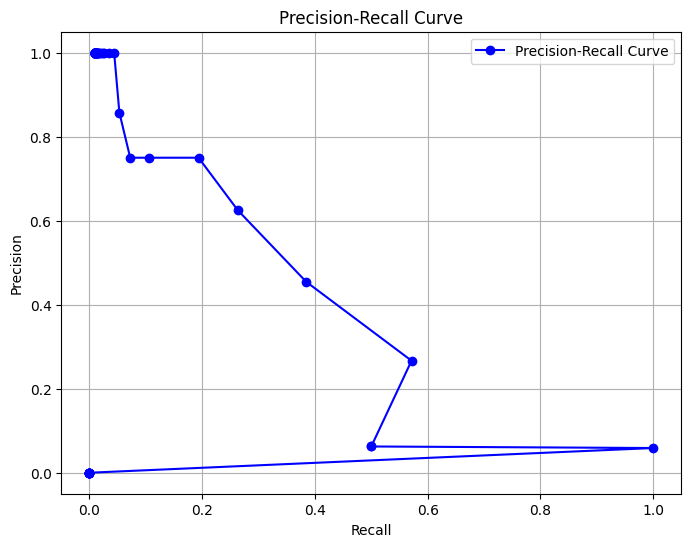

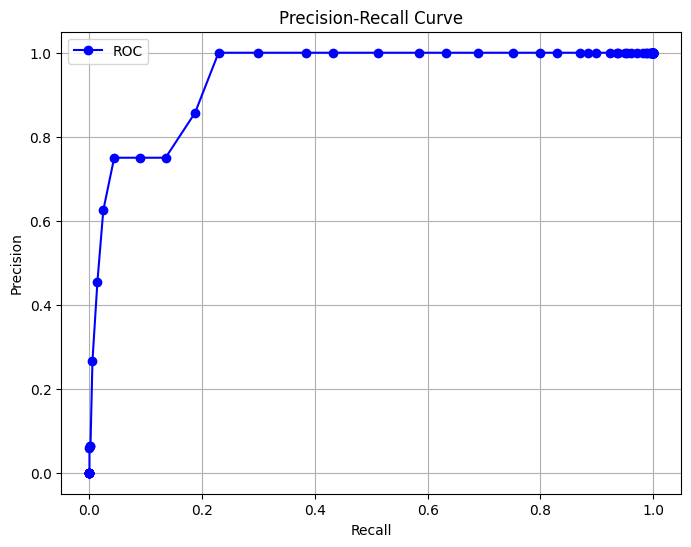

Low Level Goals AUC: 0.9428537166437039


In [ ]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals PREC REC AUC:", auc_prec_rec)

recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.166666666652777

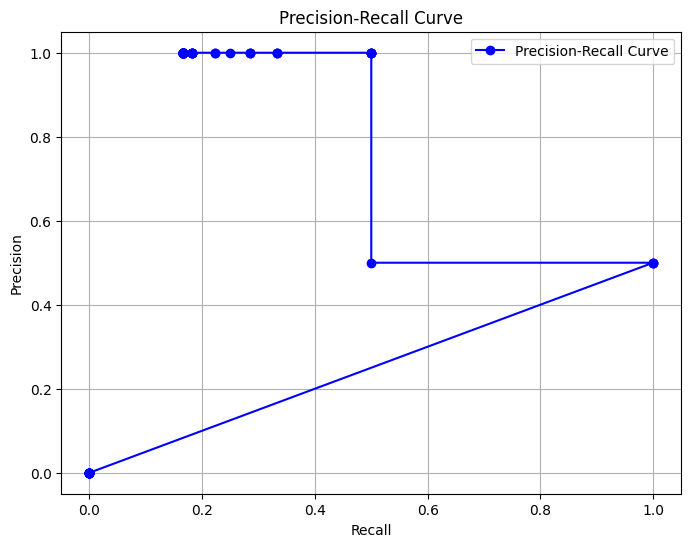

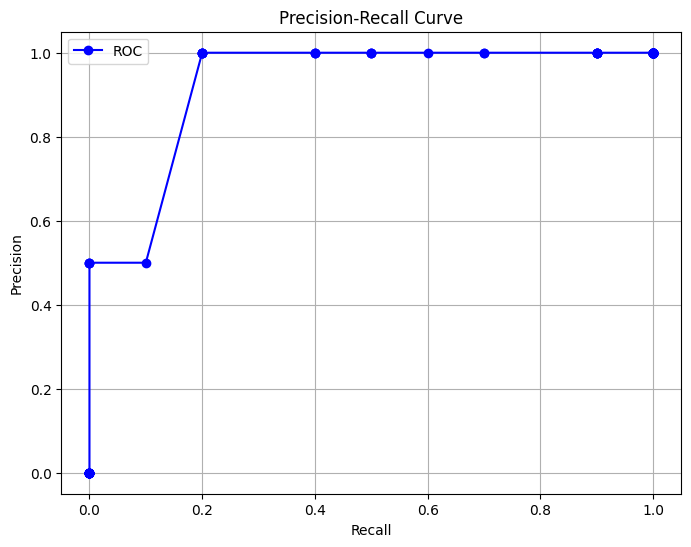

Actors AUC: 0.924999999445


In [ ]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors PREC REC AUC:", auc_prec_rec)